# Summarize the results from using weighted and unweighted onto-VAE

In [1]:
## modules

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import colorcet as cc
from scipy import stats
import neptune
from neptune.types import File
from statsmodels.stats.multitest import fdrcorrection

In [2]:
## import the results summary table
terms_summary_df = pd.read_csv('results/terms_summary_df.csv', sep=",")
terms_summary_df.rename(columns={'tissues_used': 'Tissues', 
                                 'weights_used': 'Weights',
                                 'term_name': 'Term',
                                 'term_auc': 'AUC',
                                 'term_qval': 'qvalue'}, inplace=True)

In [ ]:
## initilaize neptune
run = neptune.init_run(
    project="",
    api_token="",
)

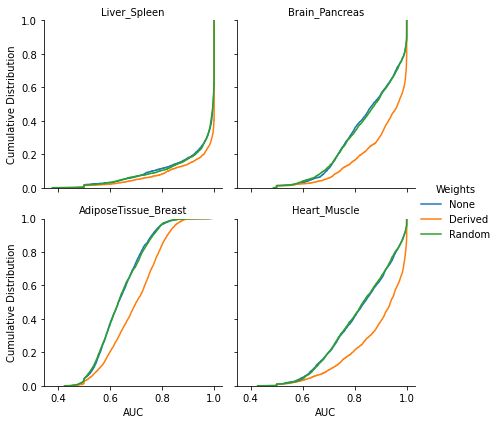

In [4]:
## plot AUC ECDF curves
g = sns.FacetGrid(terms_summary_df, col = 'Tissues',hue = "Weights", col_wrap=2)
g.map(sns.ecdfplot, "AUC", complementary=False)
g.set_titles(col_template="{col_name}")
g.add_legend()
g.set_ylabels("Cumulative Distribution")
g.savefig("results/AUC_EDCF_plots.pdf")
g.savefig("results/AUC_EDCF_plots.png")

## save to neptune
run["images/AUC-EDCF-plots-pdf"].upload("results/AUC_EDCF_plots.pdf")
run["images/AUC-EDCF-plots-png"].upload("results/AUC_EDCF_plots.png")


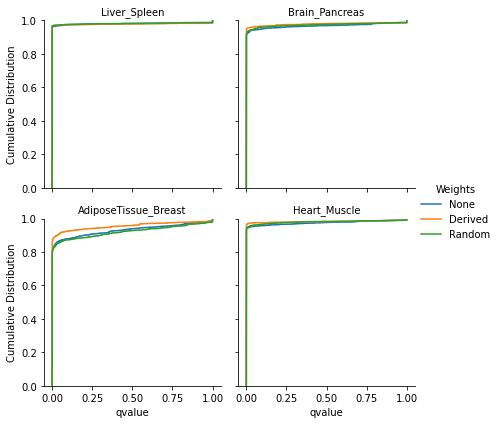

In [5]:
## plot qvalue ECDF curves
g = sns.FacetGrid(terms_summary_df, col = 'Tissues',hue = "Weights", col_wrap=2)
g.map(sns.ecdfplot, "qvalue", complementary=False)
g.set_titles(col_template="{col_name}")
g.add_legend()
g.set_ylabels("Cumulative Distribution")
g.savefig("results/qvalue_EDCF_plots.pdf")
g.savefig("results/qvalue_EDCF_plots.png")

# save to neptune

run["images/qvalue-EDCF-plots-pdf"].upload("results/qvalue_EDCF_plots.pdf")
run["images/qvalue-EDCF-plots-png"].upload("results/qvalue_EDCF_plots.png")

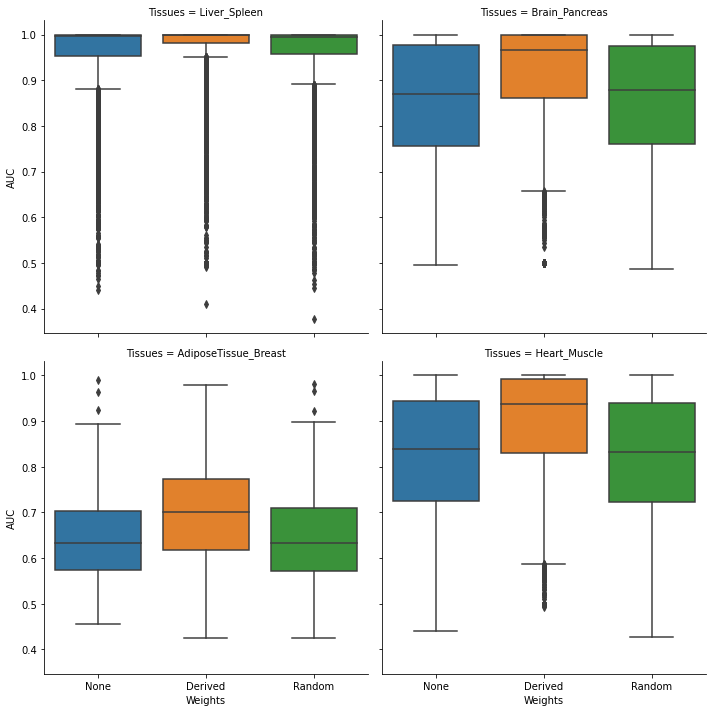

In [6]:
## boxplots

sns.catplot(
    data=terms_summary_df, x='Weights', y='AUC',
    col='Tissues', kind='box', col_wrap=2
    # , whis=(0, 100)
    )

plt.savefig("results/AUC_boxplots.pdf")
plt.savefig("results/AUC_boxplots.png")

run["images/AUC-boxplots-pdf"].upload("results/AUC_boxplots.pdf")
run["images/AUC-boxplots-png"].upload("results/AUC_boxplots.png")

In [7]:
## statistical test of auc values
Tissues_unique = terms_summary_df['Tissues'].unique()
wilcox_auc_tissues = []
wilcox_auc_pvalues = []

for tu in Tissues_unique:
    wilcox_auc_tissues.append(tu)
    scores_to_test = terms_summary_df[terms_summary_df['Tissues']==str(tu)].copy().pivot(index = 'Term', columns = 'Weights', values = 'AUC')
    scores_tested = stats.wilcoxon(x = np.asarray(scores_to_test['Derived']),y = np.asarray(scores_to_test['None']))
    wilcox_auc_pvalues.append(scores_tested.pvalue)

wilcox_auc = pd.DataFrame({
    'wilcox_auc_tissues': wilcox_auc_tissues,
    'wilcox_auc_pvalues': wilcox_auc_pvalues 
})

wilcox_auc.to_csv('results/wilcox_auc_derived_none.csv', index=False)

run["data/wilcox-auc-derived-none-html"].upload(File.as_html(wilcox_auc))

In [8]:
## terms ranked by change in AUC
Tissues_unique = terms_summary_df['Tissues'].unique()
for tu in Tissues_unique:
    scores_to_rank = terms_summary_df[terms_summary_df['Tissues']==str(tu)].copy().pivot(index = 'Term', columns = 'Weights', values = 'AUC')
    scores_to_rank.loc[:,'Tissues'] = tu
    scores_to_rank['AUC_change'] = scores_to_rank['Derived'] - scores_to_rank['None']
    scores_to_rank['AUC_change_rank'] = scores_to_rank['AUC_change'].rank(ascending=False)
    scores_to_rank.sort_values(by=['AUC_change_rank'], inplace=True)
    scores_to_rank.to_csv('results/auc_ranks_derived_non_'+str(tu)+'.csv')
    run['data/auc-ranks-derived-non-'+str(tu.replace("_","-"))+'-html'].upload(File.as_html(scores_to_rank))

In [10]:
run.stop()